# Self-supervised learning

In the course so far, we’ve primarily encountered two dominant paradigms in machine learning: supervised and unsupervised learning. Supervised approaches have formed the backbone of much of our discussion, where models are trained on labeled datasets to learn mappings from inputs to known outputs—ranging from image classification to sequence labeling tasks. These methods rely heavily on the availability of annotated data, which can be costly or impractical to obtain at scale. On the other hand, we’ve also explored unsupervised learning techniques, which forgo labels entirely and instead aim to uncover structure or patterns inherent in the data itself. This includes clustering and dimensionality reduction. Self-supervised learning, in particular, has emerged as a powerful middle ground—leveraging the scale and flexibility of unsupervised data while achieving performance that often rivals supervised methods, without requiring manual annotation.

This notebook presents a detailed walkthrough of the [DINOv2](https://arxiv.org/abs/2304.07193) model.

## 1. The Rise of Self-Supervised Learning

In recent years, self-supervised learning (SSL) has gained momentum in computer vision. With the explosion of data available online, manually labeling millions or billions of images has become prohibitively expensive. SSL leverages the inherent structure in data to learn robust representations without relying on costly annotations. Models like DINOv2 demonstrate how powerful feature representations can be learned from unlabeled data, and these features can then be adapted to a variety of downstream tasks such as classification, segmentation, and retrieval, as we will see below.

![dinov2](images/dinov2.png)


To construct the training corpus, the authors draw from a wide array of sources, primarily leveraging Meta's internal data lake. This includes a mix of public datasets, such as ImageNet and OpenImages, along with a significantly larger proprietary compilation referred to as LVD-142M (Large-scale Visual Data), which contains approximately 142 million images. The goal was to achieve broad coverage across different domains—ranging from natural scenes to human-made environments.

Images are first filtered through a pipeline, which includes eliminating low-resolution, low-contrast, or blank images, and performing near-duplicate removal using perceptual hashing and, in some cases, CLIP-based similarity measures. The emphasis is not only on raw quantity but also on ensuring that the images retained are both meaningful and diverse in content.

To prevent overrepresentation of common patterns such as human faces, animals, or heavily text-laden content, the authors implemented heuristics that favor a balanced sampling across object categories, spatial scales, and visual textures. In some configurations, CLIP embeddings are used to measure semantic diversity directly, helping filter out redundant or overly narrow image subsets. This encourages the inclusion of both coarse- and fine-grained features across different visual contexts.

The final preprocessing step involves resizing and cropping the images to match the input resolution expected by Vision Transformers (224×224 for base models, up to 518×518 for larger ones). Standard data augmentation techniques like random cropping, color jitter, and Gaussian blur are used during training to create multiple views of each image. Importantly, the entire process remains self-supervised—no class labels or bounding boxes are used at any stage.

## 2. Loading the Pre-trained DINOv2 Model

We load the pre-trained DINOv2 model using `torch.hub`. The model is set to evaluation mode for feature extraction.

In [1]:
import torch

model_name = 'dinov2_vits14_reg'  
model = torch.hub.load('facebookresearch/dinov2', model_name)

model.eval()
print(f'Loaded {model_name} successfully.')

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/moralesmurallesm/.cache/torch/hub/main.zip
/home/moralesmurallesm/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/moralesmurallesm/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/moralesmurallesm/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_reg4_pretrain.pth" to /home/moralesmurallesm/.cache/torch/hub/checkpoints/dinov2_vits14_reg4_pretrain.pth
100%|██████████| 84.2M/84.2M [00:01<00:00, 81.0MB/s]


Loaded dinov2_vits14_reg successfully.


## 3. Feature Extraction with DINOv2

Before applying DINOv2 to any task, we preprocess images by resizing, cropping, and normalizing them using ImageNet statistics. We then extract the dinov2 features from the preprocessed image. In the cell below, we demonstrate this using an example image.

In [2]:
from torchvision import transforms
from PIL import Image

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load an example image
image = Image.open('images/American_Alligator.jpg').convert('RGB')
input_tensor = preprocess(image).unsqueeze(0)  
with torch.no_grad():
    features = model(input_tensor)

print('Global feature vector shape:', features.shape)


Global feature vector shape: torch.Size([1, 384])


## 4. Use Case: CIFAR-100 Image Classification

In this section, we demonstrate how to use DINOv2 features for image classification on the CIFAR-100 (32 x 32 pixels) dataset. We load the dataset, extract features using DINOv2, and then train a simple linear classifier on top of these features. Let's start by defining our preprocessing pipeline and our dataloaders

In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import random

# Set random seed for reproducibility
random.seed(42)

# Define transforms
cifar_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load full datasets
train_dataset_full = datasets.CIFAR100(root='./data', train=True, download=True, transform=cifar_transform)
test_dataset_full = datasets.CIFAR100(root='./data', train=False, download=True, transform=cifar_transform)

# Subsample
n_train = 5000
n_test = 1000
train_indices = random.sample(range(len(train_dataset_full)), n_train)
test_indices = random.sample(range(len(test_dataset_full)), n_test)

train_dataset = Subset(train_dataset_full, train_indices)
test_dataset = Subset(test_dataset_full, test_indices)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4)

print(f'CIFAR-100 subset loaded: {n_train} training samples, {n_test} test samples.')


100%|██████████| 169M/169M [00:03<00:00, 49.4MB/s] 


CIFAR-100 subset loaded: 5000 training samples, 1000 test samples.


/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Now we need to define a linear probe to add to our encoder model. This will have input dimensions corresponding to the feature_dim of dinov2 and output dimensions corresponding to the CIFAR dataset.

In [5]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda')
model.to(device)

class LinearClassifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(in_features, num_classes)
    def forward(self, x):
        return self.fc(x)

# Update feature_dim to match the output of your DINOv2 model (if you change the model to other architectures)
feature_dim = 384
num_classes = 100
classifier = LinearClassifier(feature_dim, num_classes).to(device)

for param in model.parameters():
    param.requires_grad = False

optimizer = optim.Adam(classifier.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

def extract_features(batch):
    with torch.no_grad():
        feats = model(batch)
    return feats
    
def train_classifier(epochs=5):
    classifier.train()
    for epoch in range(epochs):
        running_loss = 0.0
        batch_count = 0
        print(f"Starting epoch {epoch+1}/{epochs}")
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            feats = extract_features(inputs)
            outputs = classifier(feats)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_count += 1
        avg_loss = running_loss / batch_count
        print(f"Epoch {epoch+1} complete, Average Loss: {avg_loss:.4f}")
    print("Training complete.")

def evaluate_classifier():
    classifier.eval()
    correct = 0
    total = 0
    print("Evaluating classifier...")
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            feats = extract_features(inputs)
            outputs = classifier(feats)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Evaluation complete. Accuracy: {accuracy:.2f}%")


In [6]:
train_classifier(epochs=5)


Starting epoch 1/5


Epoch 1: 100%|██████████| 10/10 [00:07<00:00,  1.32batch/s]


Epoch 1 complete, Average Loss: 1.8988
Starting epoch 2/5


Epoch 2: 100%|██████████| 10/10 [00:07<00:00,  1.42batch/s]


Epoch 2 complete, Average Loss: 0.4766
Starting epoch 3/5


Epoch 3: 100%|██████████| 10/10 [00:07<00:00,  1.41batch/s]


Epoch 3 complete, Average Loss: 0.2461
Starting epoch 4/5


Epoch 4: 100%|██████████| 10/10 [00:07<00:00,  1.40batch/s]


Epoch 4 complete, Average Loss: 0.1350
Starting epoch 5/5


Epoch 5: 100%|██████████| 10/10 [00:06<00:00,  1.44batch/s]

Epoch 5 complete, Average Loss: 0.0822
Training complete.


In [7]:
evaluate_classifier()

Evaluating classifier...


Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.09batch/s]

Evaluation complete. Accuracy: 77.60%


## 5. Use Case: Unsupervised Segmentation with DINOv2 Features

DINOv2 not only produces strong global representations but also learns spatially rich features. In this section, we demonstrate a simple unsupervised segmentation approach. 

We use the model's intermediate method (`forward_features`) that outputs patch tokens. These tokens (excluding any class token) are reshaped into a grid corresponding to image patches. We then perform k-means clustering on these patch features to segment the image into regions with similar characteristics.

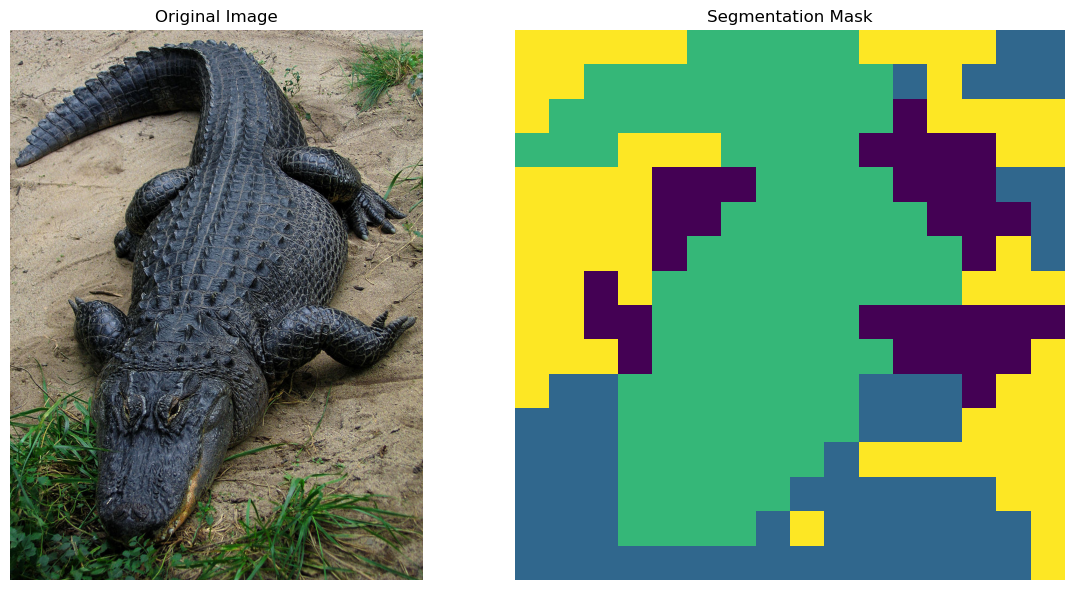

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def extract_patch_features(image_tensor):
    with torch.no_grad():
        out = model.forward_features(image_tensor)
    if isinstance(out, dict):
        if 'x_norm_patchtokens' in out:
            patch_tokens = out['x_norm_patchtokens']
        else:
            raise ValueError("Expected 'x_norm_patchtokens' key not found in model output.")
    else:
        patch_tokens = out

    num_tokens = patch_tokens.shape[1]
    grid_size = int(np.sqrt(num_tokens))
    patch_tokens = patch_tokens.reshape(grid_size * grid_size, -1)
    return patch_tokens, grid_size

def segment_image(image_tensor, n_clusters=6):
    patch_feats, grid_size = extract_patch_features(image_tensor)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(patch_feats.cpu().numpy())
    labels = kmeans.labels_.reshape(grid_size, grid_size)
    return labels

# Load the same example image
image = Image.open('images/American_Alligator.jpg').convert('RGB')
input_tensor = preprocess(image).unsqueeze(0).to(device)
seg_labels = segment_image(input_tensor, n_clusters=4)
    
plt.figure(figsize=(12,6))
    
# Display original image
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
    
# Display segmentation mask
plt.subplot(1,2,2)
plt.imshow(seg_labels, cmap='viridis')
plt.title('Segmentation Mask')
plt.axis('off')
    
plt.tight_layout()
plt.show()


Now we can try without clustering, but illustrating features using a PCA

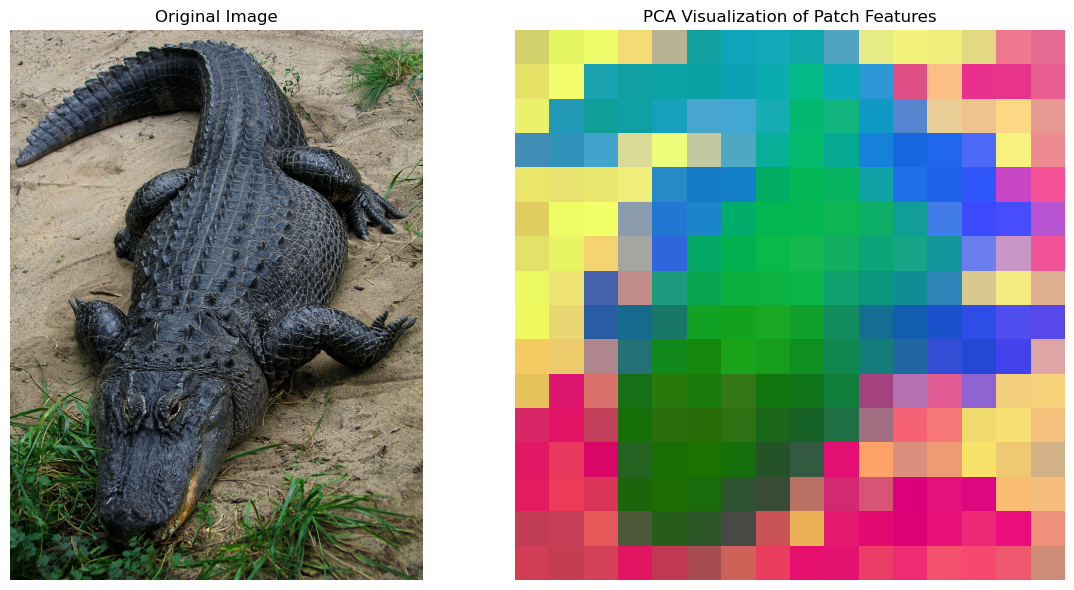

In [9]:
from sklearn.decomposition import PCA

def visualize_pca_features(image_tensor):
    patch_tokens, grid_size = extract_patch_features(image_tensor)
    # Perform PCA to reduce features to 3 dimensions
    pca = PCA(n_components=3)
    pca_features = pca.fit_transform(patch_tokens.cpu().numpy())
    # Normalize each channel to the [0,1] range for visualization
    pca_features = (pca_features - pca_features.min(axis=0)) / (pca_features.max(axis=0) - pca_features.min(axis=0) + 1e-8)
    # Reshape to the grid dimensions (H, W, 3)
    pca_image = pca_features.reshape(grid_size, grid_size, 3)
    return pca_image

# Load the same example image and visualize PCA features alongside the original image
image = Image.open('images/American_Alligator.jpg').convert('RGB')
input_tensor = preprocess(image).unsqueeze(0).to(device)
pca_image = visualize_pca_features(input_tensor)
    
plt.figure(figsize=(12,6))
# Original image
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
    
# PCA feature visualization
plt.subplot(1,2,2)
plt.imshow(pca_image)
plt.title('PCA Visualization of Patch Features')
plt.axis('off')
    
plt.tight_layout()
plt.show()


## 7. Use Case: Image Retrieval using DINOv2 Features

Another powerful application of DINOv2 is image retrieval. In this demonstration, we compute global features for a subset of images (using CIFAR-100 as an example) and, given a query image, retrieve the most similar images based on cosine similarity of their feature vectors. Let's start by extracting the features:

In [10]:
from torch.utils.data import Subset

def extract_global_feature(image_tensor):
    with torch.no_grad():
        feat = model(image_tensor)
    return feat
    
def unnormalize(img, mean, std):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img
    
def compute_dataset_features(dataset, subset_size=100):
    indices = list(range(subset_size))
    subset = Subset(dataset, indices)
    loader = DataLoader(subset, batch_size=32, shuffle=False)
    features_list = []
    images_list = []
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            feats = model(imgs)
            features_list.append(feats.cpu())
            images_list.extend([img for img in imgs.cpu()])
    features = torch.cat(features_list, dim=0)
    return features, images_list

# Compute features for a subset of CIFAR-100 test images
dataset_features, dataset_images = compute_dataset_features(test_dataset, subset_size=1000)




Now let's retrieve the top5 most similar images and plot them:

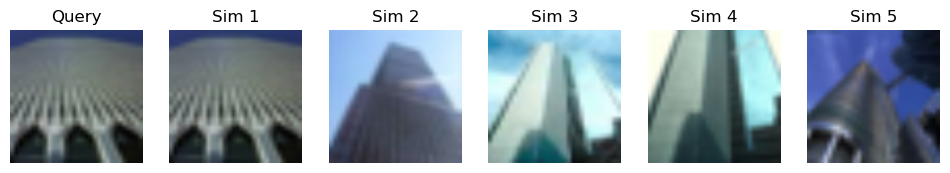

In [11]:
def retrieve_similar(query_tensor, dataset_features, top_k=5):
    query_feat = extract_global_feature(query_tensor.to(device)).cpu()
    query_norm = query_feat / query_feat.norm(dim=1, keepdim=True)
    dataset_norm = dataset_features / dataset_features.norm(dim=1, keepdim=True)
    similarities = (dataset_norm @ query_norm.t()).squeeze()
    top_indices = similarities.topk(top_k).indices
    return top_indices, similarities[top_indices]
    
# Select a random query image from the test set
import random
query_idx = random.randint(0, len(dataset_images)-1)
query_image = dataset_images[query_idx]

indices, sims = retrieve_similar(query_image.unsqueeze(0), dataset_features, top_k=5)

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

plt.figure(figsize=(12,3))
plt.subplot(1,6,1)
img = unnormalize(query_image.clone(), mean, std)
plt.imshow(img.permute(1,2,0).clamp(0,1))
plt.title('Query')
plt.axis('off')

for i, idx in enumerate(indices):
    plt.subplot(1,6,i+2)
    img = unnormalize(dataset_images[idx].clone(), mean, std)
    plt.imshow(img.permute(1,2,0).clamp(0,1))
    plt.title(f'Sim {i+1}')
    plt.axis('off')

## 8. Zero-shot Depth Estimation

In this example, we generate a depth-like map in a zero-shot, unsupervised manner using DINOv2 features. 
We extract patch tokens from a pretrained DINOv2 model, apply PCA to project them into a lower-dimensional 
space, and visualize the first few principal components as a proxy for relative depth. This method captures 
coarse scene geometry without any explicit depth supervision or fine-tuning, leveraging the strong inductive 
biases encoded in DINOv2's learned representations.


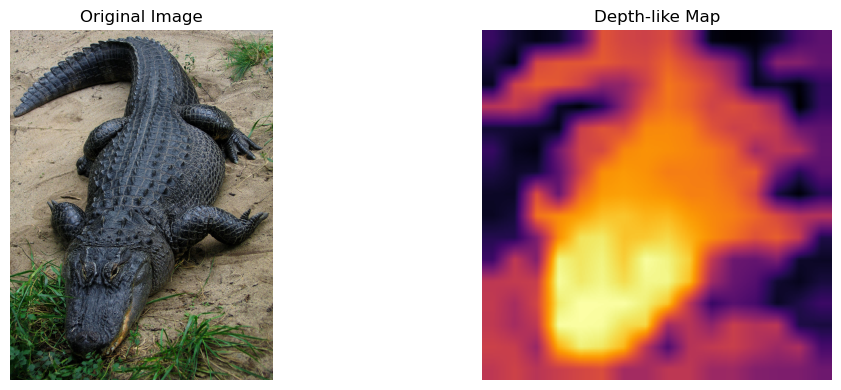

In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import math
# Load and preprocess image
torch.manual_seed(32)
from sklearn.decomposition import PCA

image = Image.open('images/American_Alligator.jpg').convert('RGB')
input_tensor = preprocess(image).unsqueeze(0).to(device)  # (1, 3, 224, 224)


# Extract patch tokens
with torch.no_grad():
    features = model.forward_features(input_tensor)
    patch_tokens = features['x_norm_patchtokens'].squeeze(0).cpu().numpy()  # (N, D)

# PCA on patch tokens
k = 3  # number of PCs to combine

pca = PCA(n_components=k)
pc_feats = pca.fit_transform(patch_tokens)  # shape: (N, 3)

# Determine grid size
N = patch_tokens.shape[0]
grid_size = int(math.sqrt(N))
assert grid_size * grid_size == N, "Patch tokens do not form a square grid"

# Visualization 2: Depth-like map
depth_map = pc_feats[:, :k].mean(axis=1)
depth_map = depth_map.reshape(grid_size, grid_size)
depth_map -= depth_map.min()
depth_map /= depth_map.max()

# Upsample both to 224x224

depth_map_up = F.interpolate(torch.tensor(depth_map).unsqueeze(0).unsqueeze(0),
                             size=(224,224), mode='bilinear', align_corners=False).squeeze().numpy()
depth_map_up = 1.0 - depth_map_up

# Original image (unnormalized)
image_vis = transforms.ToTensor()(image).permute(1, 2, 0).numpy()

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_vis)
plt.title("Original Image")
plt.axis('off')


plt.subplot(1, 2, 2)
plt.imshow(depth_map_up, cmap='inferno')
plt.title("Depth-like Map")
plt.axis('off')

plt.tight_layout()
plt.show()

## 9. Zero-shot Semantic Correspondence

This section demonstrates how DINOv2 patch embeddings can be used for semantic correspondence between two related images 
in a fully zero-shot setting. We extract patch-level features from each image, then compute dense pairwise cosine similarity 
to find the most similar patch in the second image for every patch in the first. This produces a coarse but meaningful mapping 
between semantically aligned regions—without supervision, labels, or fine-tuning. The resulting correspondences reveal how 
self-supervised DINOv2 features encode spatial semantics and object part alignment across views or instances.


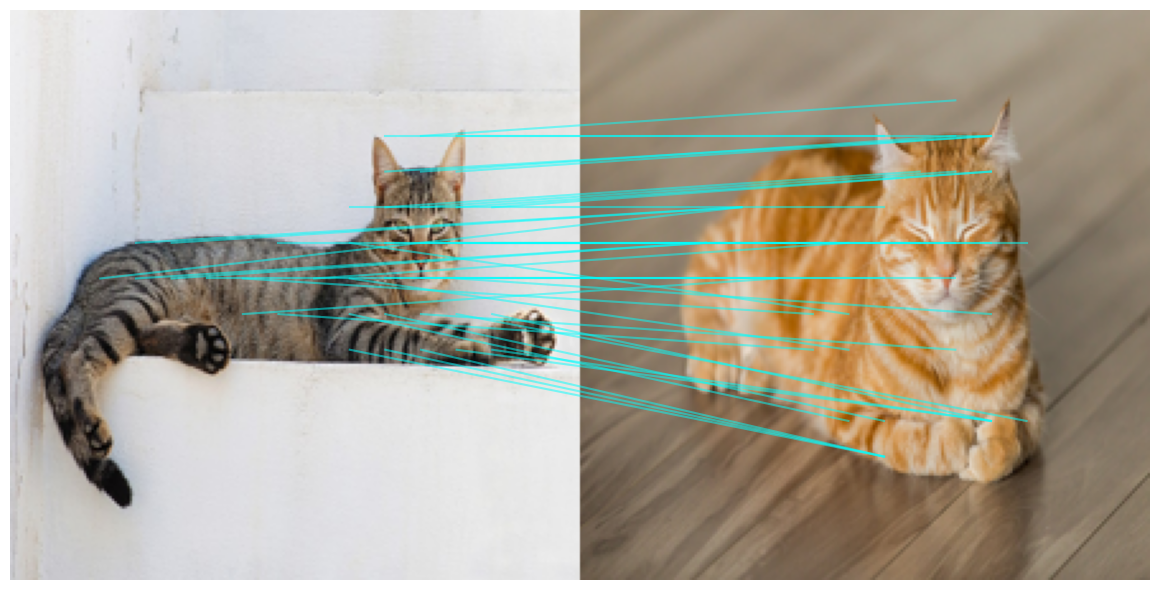

In [14]:
img1 = Image.open('images/cat1.jpg').convert('RGB')
img2 = Image.open('images/cat2.jpg').convert('RGB')

x1 = preprocess(img1).unsqueeze(0).to(device)
x2 = preprocess(img2).unsqueeze(0).to(device)

# --- Extract patch features ---
with torch.no_grad():
    f1 = model.forward_features(x1)['x_norm_patchtokens'][0]  # [N, C]
    f2 = model.forward_features(x2)['x_norm_patchtokens'][0]  # [N, C]

# --- Match patches via cosine similarity ---
sim = torch.nn.functional.cosine_similarity(f1[:, None, :], f2[None, :, :], dim=-1)  # [N, N]
matches = sim.argmax(dim=1)  # [N]

# --- Convert patch indices to 2D coordinates ---
def patch_coords(n_patches, H, W, device):
    grid_h = int(round(n_patches ** 0.5))
    grid_w = grid_h  # assume square
    assert grid_h * grid_w == n_patches, f"Expected square patch grid, got {n_patches} patches."

    y = (torch.arange(grid_h, device=device) + 0.5) * (H / grid_h)
    x = (torch.arange(grid_w, device=device) + 0.5) * (W / grid_w)
    xx, yy = torch.meshgrid(x, y, indexing='xy')
    coords = torch.stack([xx.flatten(), yy.flatten()], dim=1)
    return coords

H, W = x1.shape[-2:]
coords1 = patch_coords(f1.shape[0], H, W, device)
coords2 = patch_coords(f2.shape[0], H, W, device)

scores = sim.max(dim=1).values  # [N]
mask = scores > 0.75  # tune threshold
coords1_filtered = coords1[mask]
coords2_filtered = coords2[matches][mask]

matched_coords1 = coords1_filtered
matched_coords2 = coords2_filtered

# --- Visualization (CPU + NumPy) ---
matched_coords1 = matched_coords1.cpu().numpy()
matched_coords2 = matched_coords2.cpu().numpy()

fig, ax = plt.subplots(figsize=(12, 6))
combined_img = np.hstack([np.array(img1.resize((224, 224))), np.array(img2.resize((224, 224)))])
ax.imshow(combined_img)

for pt1, pt2 in zip(matched_coords1, matched_coords2):
    x1, y1 = pt1
    x2, y2 = pt2
    ax.plot([x1, x2 + 224], [y1, y2], color='cyan', linewidth=1.5, alpha=0.5)

ax.axis('off')
plt.tight_layout()
plt.show()